In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATASET_PATH = './housing.csv'
df = pd.read_csv(DATASET_PATH, sep=',')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Описание датасета

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

### Проанализируем полученные данные

In [4]:
# смотрим статистику по данным
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
count,20640.000000,20640.000000,19918.000000,20640.000000,20433.000000,20041.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.471242,35.036934,28.653630,2635.763081,537.870553,1425.418243,499.539680,3.870671,206855.816909,10319.500000
std,5.041408,94.903955,12.576796,2181.615252,421.385070,1135.185798,382.329753,1.899822,115395.615874,5958.399114
min,-124.350000,-13534.030000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,786.000000,280.000000,2.563400,119600.000000,5159.750000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1165.000000,409.000000,3.534800,179700.000000,10319.500000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1726.000000,605.000000,4.743250,264725.000000,15479.250000
max,122.030000,1327.130000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,20639.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  19918 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20041 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  id                  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


In [6]:
# смотрим номинативные данные
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


In [7]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9127
INLAND        6542
NEAR OCEAN    2655
NEAR BAY      2288
-               23
ISLAND           5
Name: ocean_proximity, dtype: int64

### Обработка пропусков

In [8]:
# Выяснили что у нас 23 пропуска фичи ocean_proximity, удалим их из нашего набора
df.drop(df[df['ocean_proximity'] == '-'].index, inplace=True)

In [9]:
# проверяем
df['ocean_proximity'].value_counts()

<1H OCEAN     9127
INLAND        6542
NEAR OCEAN    2655
NEAR BAY      2288
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
# смотрим количественные фичи
df.isna().sum()

longitude               0
latitude                0
housing_median_age    720
total_rooms             0
total_bedrooms        207
population            598
households              0
median_income           0
median_house_value      0
ocean_proximity         0
id                      0
dtype: int64

In [11]:
# Заполняем медианной все пропущенные фичи
median = df['total_bedrooms'].median()
df['total_bedrooms'].fillna(median, inplace=True)
median = df['housing_median_age'].median()
df['housing_median_age'].fillna(median, inplace=True)
median = df['population'].median()
df['population'].fillna(median, inplace=True)

In [12]:
# Проверяем что все хорошо
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
id                    0
dtype: int64

In [13]:
# оптимизируем типы данных
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.89 MB
Memory usage after optimization is: 0.92 MB
Decreased by 51.0%


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20617 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20617 non-null  float32 
 1   latitude            20617 non-null  float32 
 2   housing_median_age  20617 non-null  float32 
 3   total_rooms         20617 non-null  float32 
 4   total_bedrooms      20617 non-null  float32 
 5   population          20617 non-null  float32 
 6   households          20617 non-null  float32 
 7   median_income       20617 non-null  float32 
 8   median_house_value  20617 non-null  float32 
 9   ocean_proximity     20617 non-null  category
 10  id                  20617 non-null  int16   
dtypes: category(1), float32(9), int16(1)
memory usage: 946.5 KB


### Анализ данных

In [15]:
# Переведем категориальные данные в числовые
df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)
# удалим обработанную колонку
# df = df.drop(columns=['ocean_proximity'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,0,0,0,1,0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1,0,0,0,1,0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2,0,0,0,1,0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3,0,0,0,1,0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,4,0,0,0,1,0


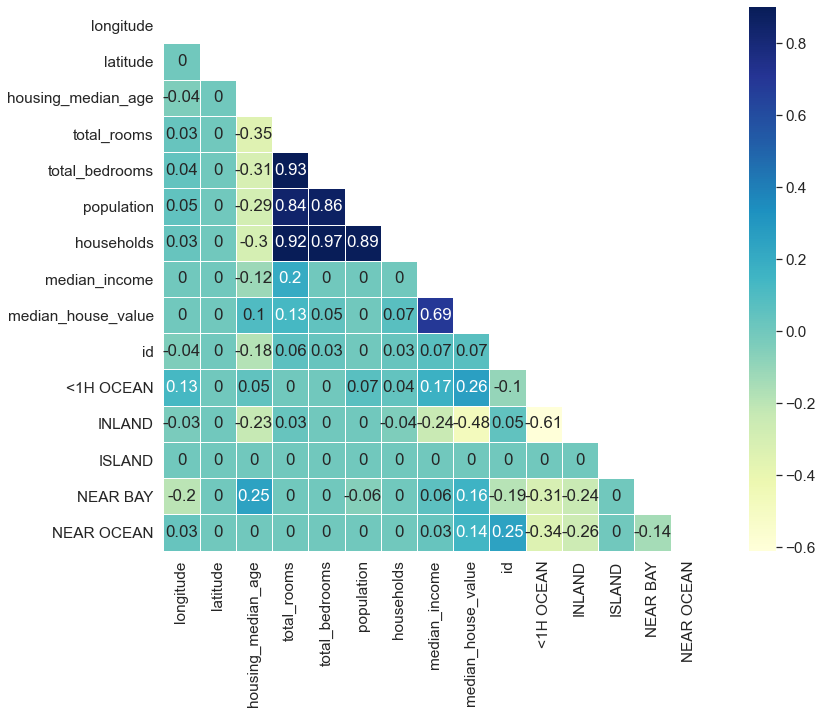

In [16]:
# смотрим линейную связь
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.03] = 0
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=.5, cmap='YlGnBu', vmax=0.9, square=True)

In [17]:
# видим зависимость у фич total_bedrooms, population, households
# исследуем их на выбросы

df['total_bedrooms'].describe()

count    20617.000000
mean       536.937378
std        419.465088
min          1.000000
25%        297.000000
50%        435.000000
75%        643.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

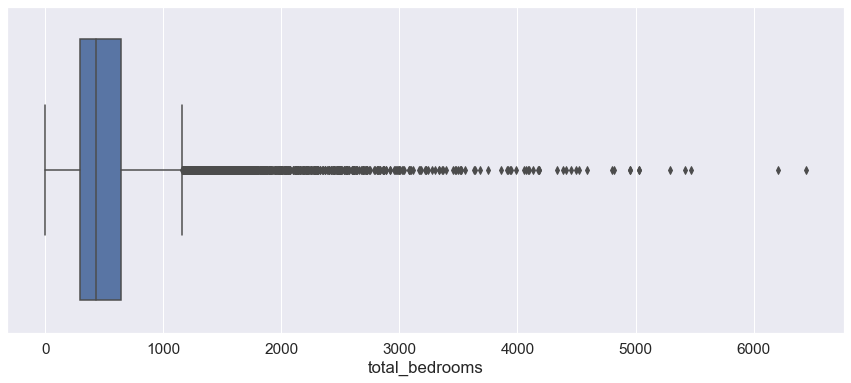

In [18]:
# нарисуем boxplot
plt.figure(figsize=(15, 6))

sns.boxplot(df['total_bedrooms'], whis=1.5)
plt.xlabel('total_bedrooms')
plt.show()

In [19]:
# определяем правую границу
qw = 643 - 297
r = 643 + 1.5*qw

In [20]:
# исправляем выбросы
df.loc[df['total_bedrooms'] > r, 'total_bedrooms'] = df['total_bedrooms'].median()
df['total_bedrooms'].describe()

count    20617.000000
mean       455.194397
std        226.222198
min          1.000000
25%        297.000000
50%        435.000000
75%        575.000000
max       1161.000000
Name: total_bedrooms, dtype: float64

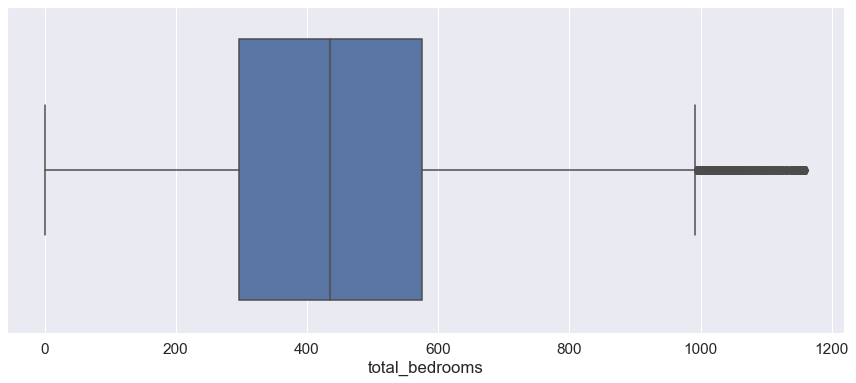

In [21]:
plt.figure(figsize=(15, 6))

sns.boxplot(df['total_bedrooms'], whis=1.5)
plt.xlabel('total_bedrooms')
plt.show()

In [22]:
# population
df['population'].describe()

count    20617.000000
mean      1418.200317
std       1119.694580
min          3.000000
25%        798.000000
50%       1165.000000
75%       1701.000000
max      35682.000000
Name: population, dtype: float64

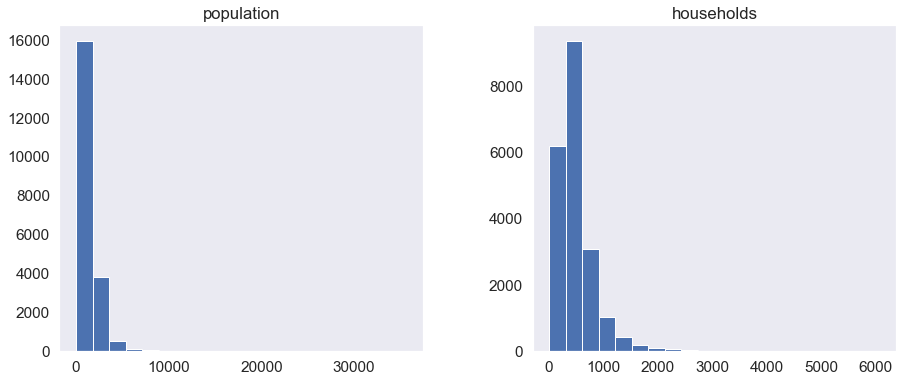

In [23]:
# population и households
df_num_features = df[['population', 'households']]
df_num_features.hist(figsize=(15,6), bins=20, grid=False);

In [24]:
# обрабатываем выбрасы в фичи population и households
df.loc[df['population'] > 4000, 'population'] = df['population'].median()

In [25]:
df.loc[df['households'] > 2000, 'households'] = df['households'].median()

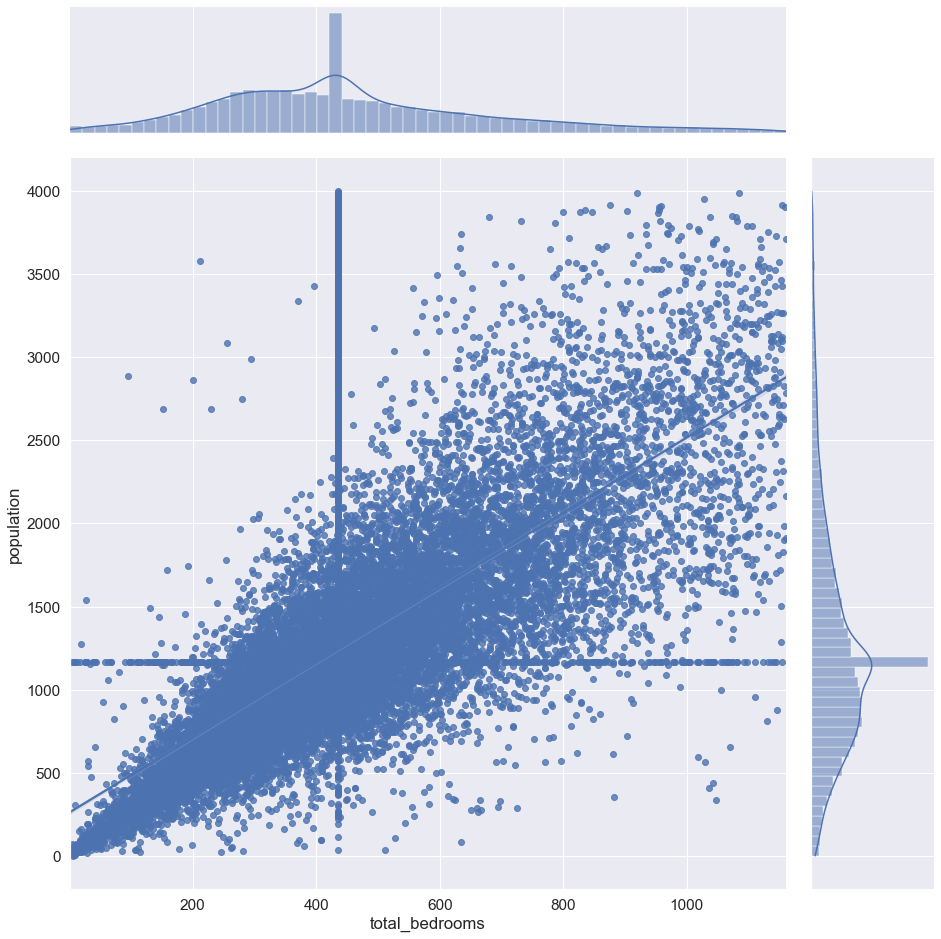

In [26]:
# смотрим зависимость между total_bedrooms и population
grid = sns.jointplot(df['total_bedrooms'], df['population'], kind="reg")
grid.fig.set_figwidth(15)
grid.fig.set_figheight(15)

plt.show()

In [27]:
# по виду, наблюдается линейная зависимость между количеством спален и человек. создадим новую переменную
# Сколько человек в среднем живут в одной спальне
df['population_per_bedrooms'] = df['population'] / df['total_bedrooms']

In [28]:
# долгота Колифорнии -117.9859000
# смотрим какая долгота выбивается
df[df['longitude'] >= 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_bedrooms
3479,118.510002,34.290001,29.0,1287.0,194.0,525.0,187.0,6.4171,319300.0,<1H OCEAN,3479,1,0,0,0,0,2.706186
5904,118.430000,34.290001,39.0,1769.0,410.0,1499.0,390.0,3.1212,153500.0,<1H OCEAN,5904,1,0,0,0,0,3.656098
8405,118.360001,33.930000,40.0,1625.0,500.0,2036.0,476.0,2.6298,156500.0,<1H OCEAN,8405,1,0,0,0,0,4.072000
8636,118.410004,33.880001,43.0,2492.0,449.0,1033.0,437.0,7.9614,500001.0,<1H OCEAN,8636,1,0,0,0,0,2.300668
13051,121.290001,38.610001,17.0,13553.0,435.0,1165.0,410.0,3.9727,132700.0,INLAND,13051,0,1,0,0,0,2.678161
15263,117.269997,33.020000,21.0,2144.0,340.0,928.0,344.0,5.7980,286100.0,NEAR OCEAN,15263,0,0,0,0,1,2.729412
17085,0.000000,37.470001,33.0,1266.0,415.0,1991.0,334.0,2.9200,202800.0,NEAR OCEAN,17085,0,0,0,0,1,4.797590
17359,0.000000,34.880001,4.0,3680.0,559.0,1678.0,569.0,5.0639,201700.0,<1H OCEAN,17359,1,0,0,0,0,3.001789
18551,122.029999,36.959999,28.0,1607.0,421.0,926.0,385.0,2.4250,216100.0,NEAR OCEAN,18551,0,0,0,0,1,2.199525
19423,0.000000,37.689999,5.0,9601.0,435.0,1165.0,1575.0,4.5332,195500.0,INLAND,19423,0,1,0,0,0,2.678161


In [29]:
# меняем знак для положительных чисел
df.loc[df['longitude'] > 0, 'longitude'] = df.loc[df['longitude'] > 0, 'longitude'] * -1
# приводим к медиане значения с 0-ми
df.loc[df['longitude'] == 0, 'longitude'] = df['longitude'].median()
# Проверяем
df[df['longitude'] >= 0]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_bedrooms


In [54]:
# широта Колифорнии 35.1258000
df[(df['latitude'] <= 0) | (df['latitude'] > 50)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_bedrooms
8283,-118.129997,-13534.030273,45.0,1016.0,172.0,361.0,163.0,7.5000,434500.0,NEAR OCEAN,8283,0,0,0,0,1,2.098837
12772,-121.419998,1327.130005,29.0,2217.0,536.0,1203.0,507.0,1.9412,73100.0,INLAND,12772,0,1,0,0,0,2.244403


In [30]:
# удалим их
df.drop(df[(df['latitude'] <= 0) | (df['latitude'] > 50)].index, inplace=True)

# проверяем
df[(df['latitude'] <= 0) | (df['latitude'] > 50)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_bedrooms


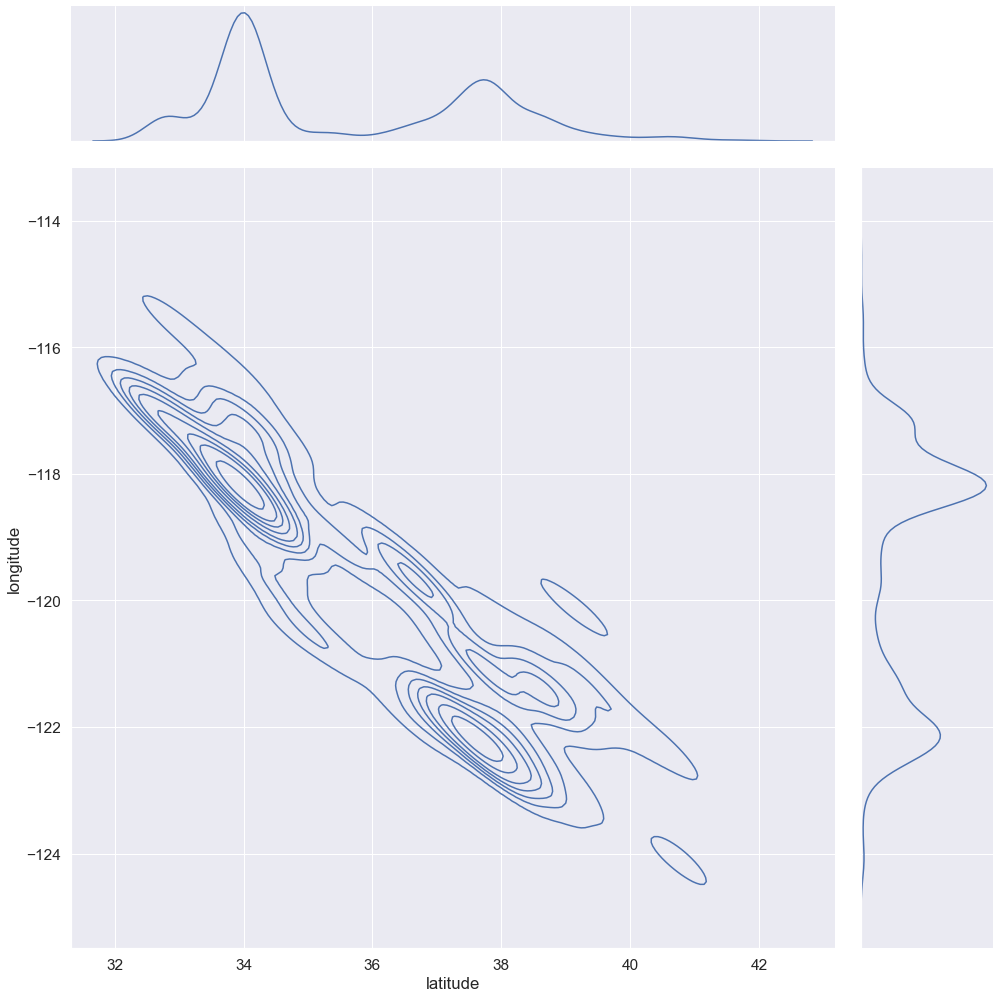

In [32]:
grid = sns.jointplot(df['latitude'], df['longitude'], kind='kde')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(16)

plt.show()

In [33]:
# разделим по городам
df['city'] = (df['latitude'] > 36) * 1

In [34]:
# смотрим что у нас с housing_median_age
df['housing_median_age'].describe()
# по виду все хорошо, оставляем как есть

count    20615.000000
mean        28.667622
std         12.355608
min          1.000000
25%         19.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

In [35]:
# смотрим что у нас с total_rooms
df['total_rooms'].describe()

count    20615.000000
mean      2636.290527
std       2182.240234
min          2.000000
25%       1448.000000
50%       2127.000000
75%       3148.000000
max      39320.000000
Name: total_rooms, dtype: float64

In [36]:
# Найдем выбросы с помощью квантилей. Наблюдения, значения которых больше 97,5% квантиля 
# и которые меньше 2,5% квантиля будем считать выбросами и заменять на медиану.

total_rooms_max_value = np.quantile(df['total_rooms'], q=0.975)
total_rooms_min_value = np.quantile(df['total_rooms'], q=0.025)
condition = (df['total_rooms'] > total_rooms_max_value) | (df['total_rooms'] < total_rooms_min_value)
df.loc[condition, 'total_rooms'] = df['total_rooms'].median()
df['total_rooms'].describe()

count    20615.000000
mean      2435.886475
std       1358.088867
min        371.000000
25%       1511.000000
50%       2127.000000
75%       3006.000000
max       8069.000000
Name: total_rooms, dtype: float64

In [37]:
# смотрим что у нас с median_income
df['median_income'].describe()
# оставляем как есть

count    20615.000000
mean         3.870683
std          1.900177
min          0.499900
25%          2.562500
50%          3.534700
75%          4.743400
max         15.000100
Name: median_income, dtype: float64

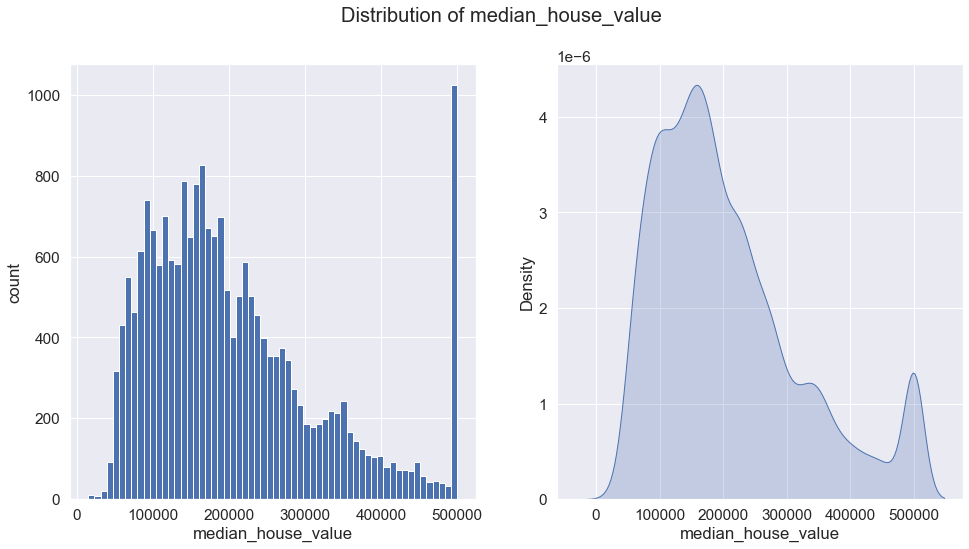

In [38]:
# смотрим распределение целевой переменной
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['median_house_value'].hist(density=False, bins=60)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.subplot(122)
sns.kdeplot(df['median_house_value'], shade=True, legend=False)
plt.xlabel('median_house_value')

plt.suptitle('Distribution of median_house_value')
plt.show()

In [39]:
df['median_house_value'].value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    102
187500.0     93
           ... 
307800.0      1
433000.0      1
304900.0      1
454300.0      1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

In [40]:
# удалим из нашей выборки все значения выше 500000
df.drop(df[(df['median_house_value'] > 500000)].index, inplace=True)


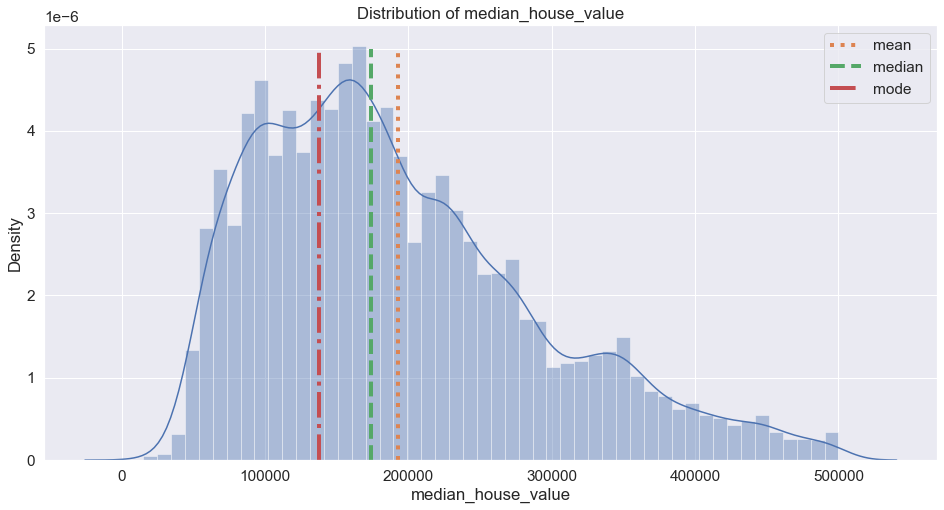

In [41]:
target_mean = round(df['median_house_value'].mean(), 2)
target_median = df['median_house_value'].median()
target_mode = df['median_house_value'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(df['median_house_value'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [42]:
# посмотрим что в итоге вышло
# берем количественные признаки с типом float, убрав целевой
df_num_features = df.select_dtypes(include=['float32'])
df_num_features.drop('median_house_value', axis=1, inplace=True)

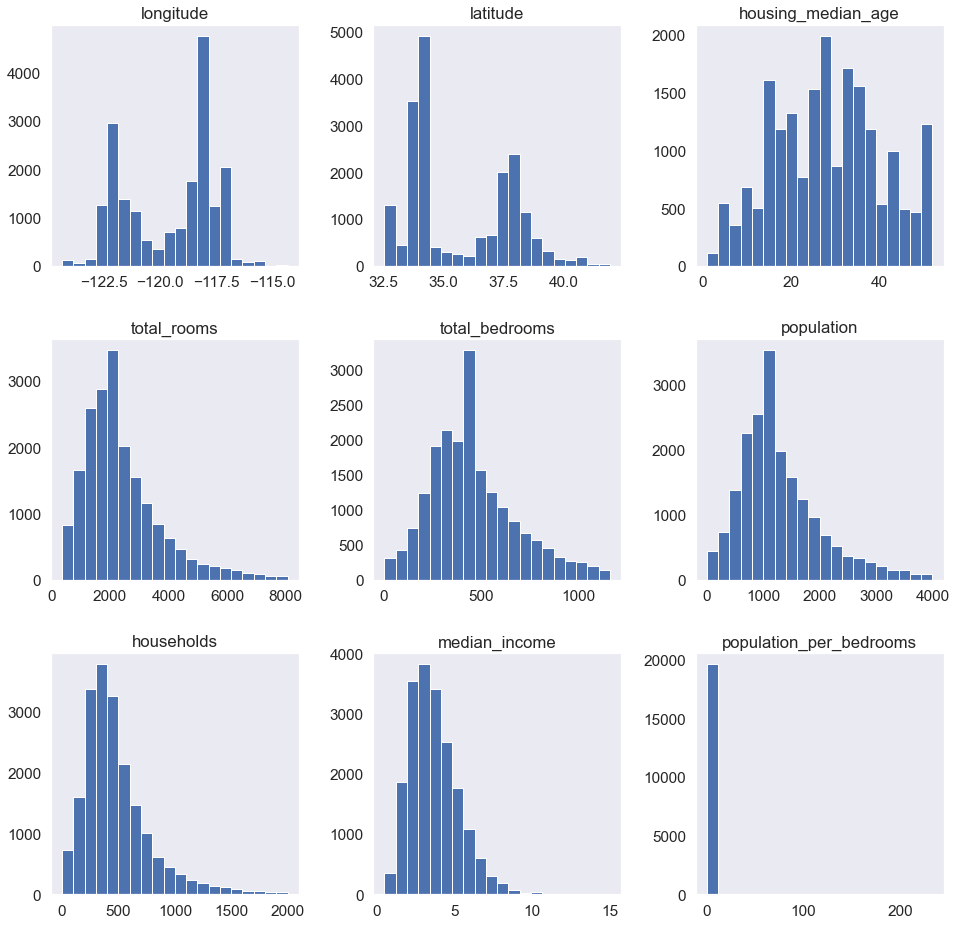

In [43]:
# строим гистограммы
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [44]:
# странный график у population_per_bedrooms
df['population_per_bedrooms'].describe()
# видим выбросы

count    19650.000000
mean         3.014571
std          2.754495
min          0.070450
25%          2.309786
50%          2.722251
75%          3.282341
max        233.000000
Name: population_per_bedrooms, dtype: float64

In [45]:
# смотрим получше
df[(df['population_per_bedrooms'] > 50)].head()
# видим что мы неверно убрали выбросы в population. 
# (когда в одной комнате проживает более 50 человек - странно)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_bedrooms,city
1633,-122.220001,37.880001,20.0,2127.0,13.0,1165.0,15.0,2.4444,475000.0,NEAR BAY,1633,0,0,0,1,0,89.615387,1
3364,-120.510002,40.410000,36.0,2127.0,8.0,1165.0,7.0,5.5179,67500.0,INLAND,3364,0,1,0,0,0,145.625000,1
4546,-118.199997,34.020000,26.0,2127.0,9.0,1165.0,9.0,1.6250,175000.0,<1H OCEAN,4546,1,0,0,0,0,129.444443,0
12104,-117.330002,33.970001,8.0,2127.0,19.0,1275.0,20.0,1.6250,162500.0,INLAND,12104,0,1,0,0,0,67.105263,0
16420,-121.290001,37.889999,26.0,2127.0,27.0,1542.0,30.0,5.7485,162500.0,INLAND,16420,0,1,0,0,0,57.111111,1


In [46]:
# скорректируем наши выбросы
df.loc[df['population_per_bedrooms'] > 7, 'population_per_bedrooms'] = df['population_per_bedrooms'].median()
df['population_per_bedrooms'].describe()

count    19650.000000
mean         2.833444
std          0.883675
min          0.070450
25%          2.309786
50%          2.722178
75%          3.209702
max          7.000000
Name: population_per_bedrooms, dtype: float64

In [47]:
# удалим колонку population
df.drop(columns=['population'], inplace=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,households,median_income,median_house_value,ocean_proximity,id,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_bedrooms,city
0,-122.230003,37.880001,41.0,880.0,129.0,126.0,8.3252,452600.0,NEAR BAY,0,0,0,0,1,0,2.496124,1
1,-122.220001,37.860001,21.0,7099.0,1106.0,1138.0,8.3014,358500.0,NEAR BAY,1,0,0,0,1,0,2.170886,1
2,-122.239998,37.849998,52.0,1467.0,190.0,177.0,7.2574,352100.0,NEAR BAY,2,0,0,0,1,0,2.610526,1
3,-122.250000,37.849998,52.0,1274.0,235.0,219.0,5.6431,341300.0,NEAR BAY,3,0,0,0,1,0,2.374468,1
4,-122.250000,37.849998,52.0,1627.0,280.0,259.0,3.8462,342200.0,NEAR BAY,4,0,0,0,1,0,2.017857,1


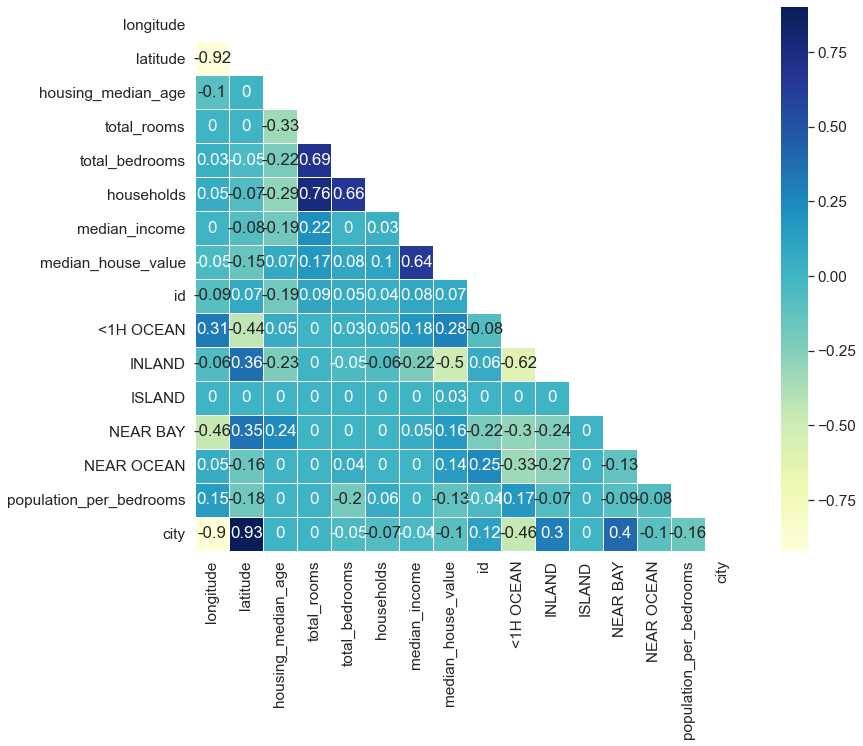

In [48]:
# еще раз взглянем на существующие линейные связи
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.03] = 0
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=.5, cmap='YlGnBu', vmax=0.9, square=True)

### Модель

In [49]:
df.keys()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'households', 'median_income', 'median_house_value',
       'ocean_proximity', 'id', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'population_per_bedrooms', 'city'],
      dtype='object')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19650 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   longitude                19650 non-null  float32 
 1   latitude                 19650 non-null  float32 
 2   housing_median_age       19650 non-null  float32 
 3   total_rooms              19650 non-null  float32 
 4   total_bedrooms           19650 non-null  float32 
 5   households               19650 non-null  float32 
 6   median_income            19650 non-null  float32 
 7   median_house_value       19650 non-null  float32 
 8   ocean_proximity          19650 non-null  category
 9   id                       19650 non-null  int16   
 10  <1H OCEAN                19650 non-null  uint8   
 11  INLAND                   19650 non-null  uint8   
 12  ISLAND                   19650 non-null  uint8   
 13  NEAR BAY                 19650 non-null  uint8   
 14  NEAR O

In [51]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 
                 'households', 'median_income', 'id', '<1H OCEAN', 'INLAND', 
                 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'population_per_bedrooms', 'city']

target_name = 'median_house_value'

In [53]:
# стандартизируем наши признаки
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32']).columns.tolist()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [54]:
stand_features.shape

(19650, 8)

In [57]:
# сохраняем в нашем df
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19650 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   longitude                18678 non-null  float32 
 1   latitude                 18678 non-null  float32 
 2   housing_median_age       18678 non-null  float32 
 3   total_rooms              18678 non-null  float32 
 4   total_bedrooms           18678 non-null  float32 
 5   households               18678 non-null  float32 
 6   median_income            18678 non-null  float32 
 7   median_house_value       19650 non-null  float32 
 8   ocean_proximity          19650 non-null  category
 9   id                       19650 non-null  int16   
 10  <1H OCEAN                19650 non-null  uint8   
 11  INLAND                   19650 non-null  uint8   
 12  ISLAND                   19650 non-null  uint8   
 13  NEAR BAY                 19650 non-null  uint8   
 14  NEAR O

In [61]:
# видим что у нас образовались пустоты но почему? не понятно(
# удалим их
df.dropna(subset=['longitude'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18678 entries, 0 to 19649
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   longitude                18678 non-null  float32 
 1   latitude                 18678 non-null  float32 
 2   housing_median_age       18678 non-null  float32 
 3   total_rooms              18678 non-null  float32 
 4   total_bedrooms           18678 non-null  float32 
 5   households               18678 non-null  float32 
 6   median_income            18678 non-null  float32 
 7   median_house_value       18678 non-null  float32 
 8   ocean_proximity          18678 non-null  category
 9   id                       18678 non-null  int16   
 10  <1H OCEAN                18678 non-null  uint8   
 11  INLAND                   18678 non-null  uint8   
 12  ISLAND                   18678 non-null  uint8   
 13  NEAR BAY                 18678 non-null  uint8   
 14  NEAR O

In [63]:
# Разбиваем датафрейм на тренировочные (X_train, y_train) и тестовые (X_test, y_test)
# с помощью функции train_test_split так, чтобы размер тестовой выборки
# составлял 20% от всех данных, при этом аргумент random_state должен быть равен 42.
X = df[feature_names]
y = df[target_name]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14942, 15), (3736, 15), (14942,), (3736,))

In [73]:
# Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [74]:
# обучим модель LinearRegression
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

R2:	0.278
RMSE:	82622.881
MSE:	6826540509.293


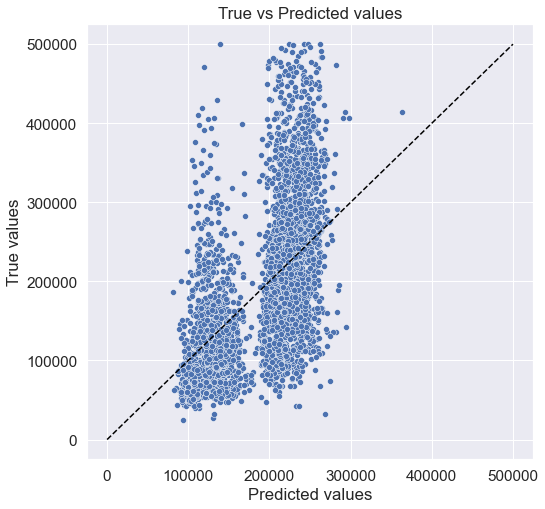

In [75]:
# проверяем на тестовом наборе
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

R2:	0.697
RMSE:	53576.416
MSE:	2870432351.159


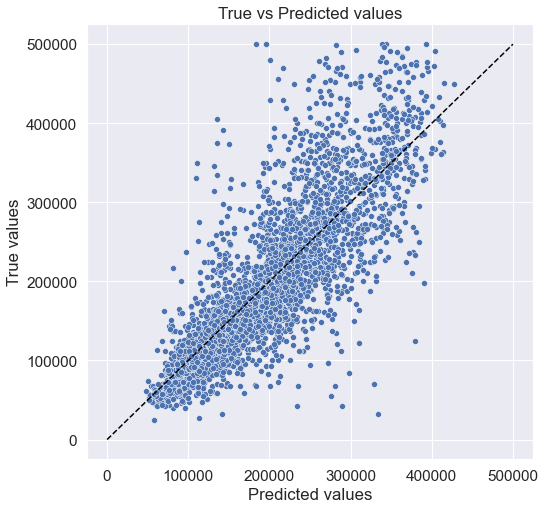

In [80]:
# попробуем RandomForestRegressor. укажем количество деревьев 800, глубиной 15
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=800, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.678
RMSE:	55183.892
MSE:	3045261978.528


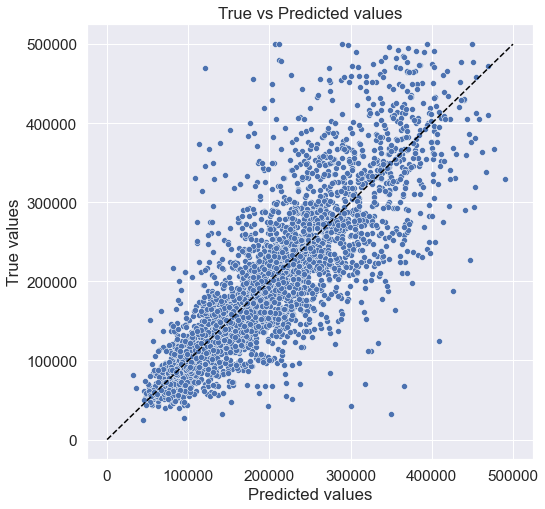

In [81]:
# попробуем GradientBoostingRegressor. укажем количество деревьев 800, глубиной 15
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(max_depth=15,
                                     random_state=42,  
                                     n_estimators=800)
gb_model.fit(X_train, y_train)

y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.014
RMSE:	96582.987
MSE:	9328273403.622


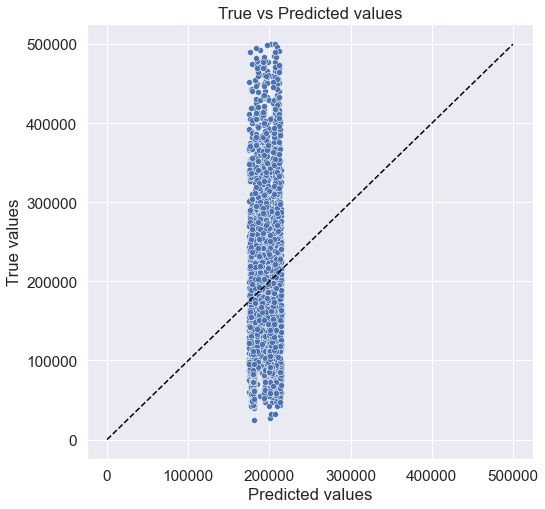

In [83]:
# глянем LassoCV
from sklearn.linear_model import LassoCV
l_cv_model = LassoCV(cv=5)
l_cv_model.fit(X_train, y_train)

y_test_preds = l_cv_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.49
RMSE:	69447.444
MSE:	4822947488.223


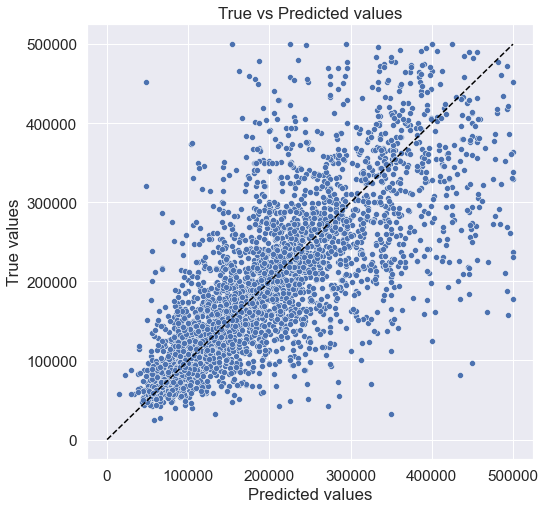

In [87]:
# посмотрим на DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(max_depth=100, random_state=42)
dt_model.fit(X_train, y_train)
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.573
RMSE:	63522.76
MSE:	4035141097.613


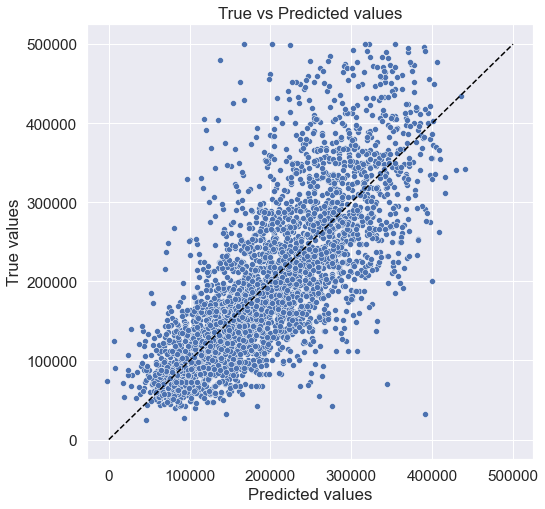

In [91]:
# попробуем LGBMRegressor (Gradient-based One-Side Sampling)
from lightgbm import LGBMRegressor
lgbm_model = LGBMRegressor(boosting_type='goss', max_depth=20, n_estimators=1000)
lgbm_model.fit(X_train, y_train)

y_test_preds = lgbm_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [101]:
# лучшие результаты показал RandomForestRegressor. поднастроем данную модель
X_train.shape[0] // 3

4980

R2:	0.671
RMSE:	56001.919
MSE:	3136214895.85


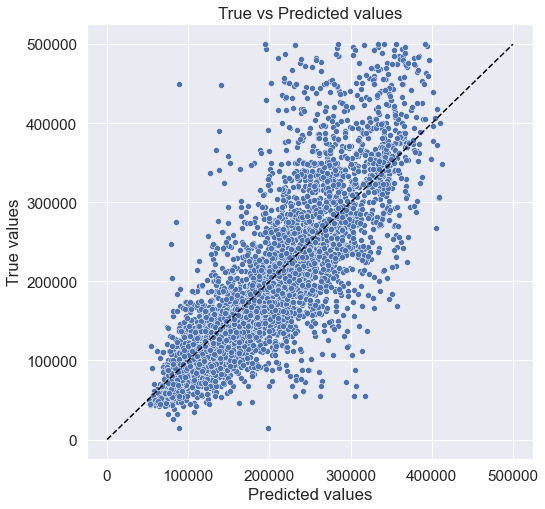

In [95]:
# Iteration_1
X_train__val_1 = X_train.iloc[:5000]
y_train__val_1 = y_train.iloc[:5000]

X_train__train_1 = X_train.iloc[5000:]
y_train__train_1 = y_train.iloc[5000:]

rf_model.fit(X_train__train_1, y_train__train_1)
y_test_preds = rf_model.predict(X_train__val_1)
evaluate_preds(y_train__val_1, y_test_preds)

R2:	0.662
RMSE:	56997.1
MSE:	3248669360.441


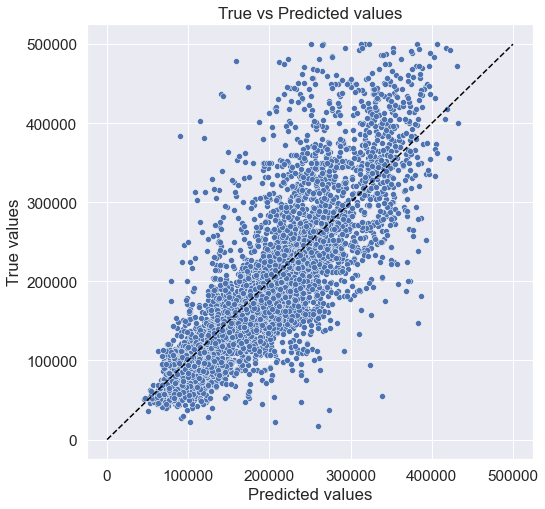

In [102]:
# Iteration_2
X_train__val_2 = X_train.iloc[5000:10000]
y_train__val_2 = y_train.iloc[5000:10000]

X_train__train_2 = X_train.drop(X_train__val_2.index)
y_train__train_2 = y_train.drop(y_train__val_2.index)

rf_model.fit(X_train__train_2, y_train__train_2)
y_test_preds = rf_model.predict(X_train__val_2)
evaluate_preds(y_train__val_2, y_test_preds)

R2:	0.671
RMSE:	55691.281
MSE:	3101518731.957


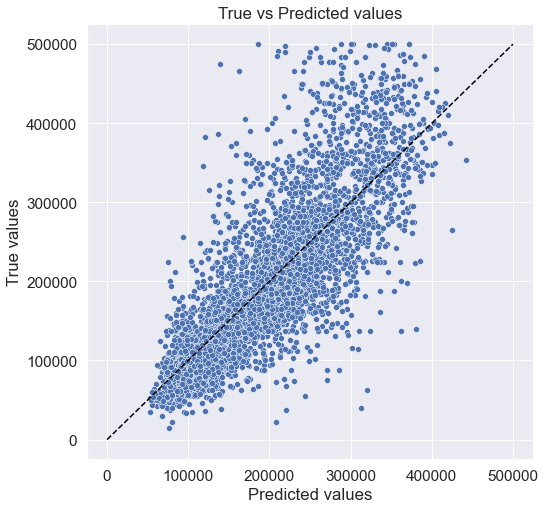

In [107]:
# Iteration_3
X_train__val_3 = X_train.iloc[10000:]
y_train__val_3 = y_train.iloc[10000:]

X_train__train_3 = X_train.drop(X_train__val_3.index)
y_train__train_3 = y_train.drop(y_train__val_3.index)

rf_model.fit(X_train__train_3, y_train__train_3)
y_test_preds = rf_model.predict(X_train__val_3)
evaluate_preds(y_train__val_3, y_test_preds)

In [108]:
R2 = np.array([0.671, 0.662, 0.671])
np.mean(R2)

0.6680000000000001

In [111]:
%%time
params = {'n_estimators':[50, 100, 400, 800], 
          'max_depth':[3, 5, 10, 15]}

from sklearn.model_selection import KFold, GridSearchCV

gs = GridSearchCV(rf_model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=5, 
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 5min


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(max_depth=15, n_estimators=800,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15],
                         'n_estimators': [50, 100, 400, 800]},
             scoring='r2')

In [112]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 800}

In [115]:
gs.best_score_

0.6809393075719206

R2:	0.697
RMSE:	53576.416
MSE:	2870432351.159


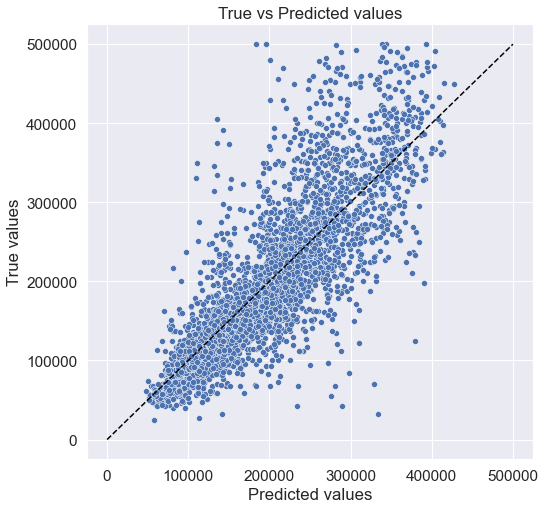

In [114]:
# финальное обучение и оценка модели
final_model = RandomForestRegressor(n_estimators=800, max_depth=15, random_state=42)

final_model.fit(X_train, y_train)
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [116]:
# определяем важность признаков 
final_model.feature_importances_

array([8.88918462e-02, 1.01925558e-01, 2.27116816e-02, 2.09310435e-02,
       1.83522079e-02, 1.73955509e-02, 4.75086848e-02, 3.74115050e-01,
       8.39212069e-03, 2.54219464e-01, 3.64706231e-04, 2.50438259e-03,
       6.45548845e-03, 3.11421101e-02, 5.09010543e-03])

In [117]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [118]:
# топ фичей
feature_importances.head(5)

,feature_name,importance
7,id,0.374115
9,INLAND,0.254219
1,latitude,0.101926
0,longitude,0.088892
6,median_income,0.047509


In [119]:
# худшие фичи
feature_importances.tail(3)

,feature_name,importance
14,city,0.005090
11,NEAR BAY,0.002504
10,ISLAND,0.000365


## Вывод. 
Тот самый момент когда id - лучшая фича... 
Из проблем: 
 - я смело удалял выбросы на этапе подготовке данных. 
 - неумело подбирал фичи для стандартизации и работы с ними
 - словил проблему что после стандартизации почему-то пропало 1000 экспериментов
 
Из плюсов:
 - научился работать с библиотеками 